# Capstone Project 

Within this project, we are tasked with considering the data Fashion MNIST made available by Zalando which consists of 70000 images which are stored as $28 \times28$ RGB values. It is important to however note, rather than 3-Dimensional RGB values, we have a one dimensional RGB value. This is due to the fact that the images are stored in greyscale, and the single RGB value represents the brightness of each pixel. A value of 0 indicate the pixel is white, and a value of 255 indicates a pixel is black.

The objective is to then perform fit various classification models to the dataset, and obtain a suitable model in a sufficiently short time which does not overfit.

Thus, the classification models which will be fitted to the data here are:
* Logistic Regression
* K-Nearest Neighbours
* Decision Tree
* Random Forest
* Support Vector Machine
* Convolutional Neural Network. 

## Preamble 

The relevant packages are imported:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

import tensorflow
import joblib

from sklearn import metrics
from datetime import datetime
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

## Loading the Data

In [2]:
fashion_mnist = tensorflow.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

Thus, the above code imports the data into 4 seperate components. Namely:
* A training set.
* The training labels.
* A testing set.
* The testing labels.

This is how the data by default is packaged.

## Exploratory Data Analysis

Not all of the exploratory analysis available with the report appears within the notebook, this is due to the fact that some graphs were far easier to obtain in R.

The images are $28 \times 28$ NumPy arrays, with pixel values ranging from 0 to 255. The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents, however the class of each clothing item is not included with the data. As such, we save these:

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

We now look at several different components of the dataset, to improve our understanding of the structure of the data as well confirm the data has indeed been imported correctly.

Thus, we see that the training dataset consists of 60000 images, each with $28\times28$ pixels.

In [5]:
train_images.shape

(60000, 28, 28)

We then confirm that we have the same number of corresponding labels for the training dataset.

In [6]:
len(train_labels)

60000

We confirm that there are no missing labels for the training dataset.

In [7]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

We now repeat the above process for the testing dataset.

In [8]:
test_images.shape

(10000, 28, 28)

In [9]:
len(test_labels)

10000

In [10]:
test_labels

array([9, 2, 1, ..., 8, 1, 5], dtype=uint8)

We then also inspect the first image within the dataset, so see that our understanding thus far of what is contained within the dataset is indeed correct.

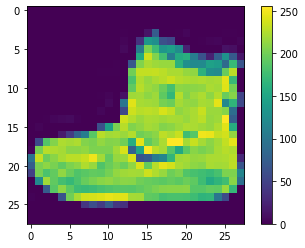

In [11]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
#plt.savefig('shoe.png')

Thus, from the above picture it appears as though the first fashion item is some sort of Nike Shoe.

While, if we then repeat the same idea as above however we consider the next 25 images in the dataset we have the following matrix of plots.

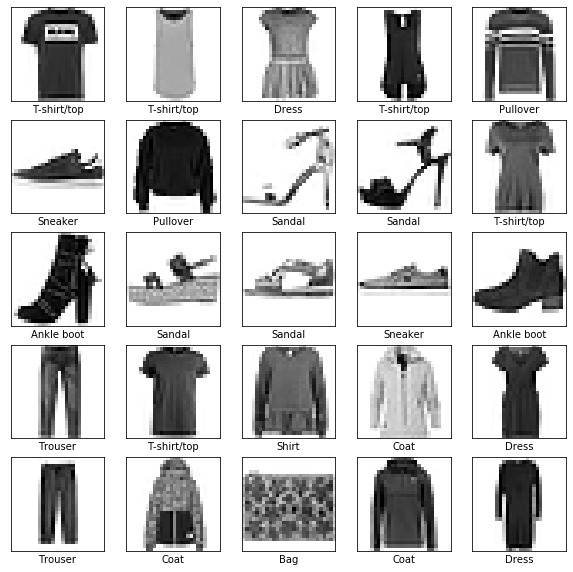

In [12]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i+1], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i+1]])
#plt.savefig('subset.png')

The last thing which we consider here is frequency plots of the various labels in both the training and testing set.

Text(0.5, 0, 'Label')

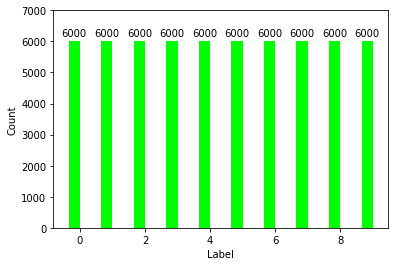

In [13]:
x = np.arange(len(class_names))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, pd.crosstab(train_labels, columns = 6000), width, label='Train', color = 'lime')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)

plt.ylim(0, 7000)
plt.ylabel("Count")
plt.xlabel("Label")
#plt.savefig('train_count.png')

Text(0.5, 0, 'Label')

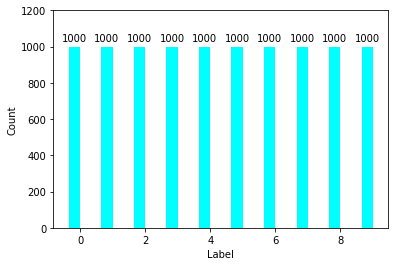

In [14]:
x = np.arange(len(class_names))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, pd.crosstab(test_labels, columns = 1000), width, label='Test', color = 'cyan')

autolabel(rects1)

plt.ylim(0, 1200)
plt.ylabel("Count")
plt.xlabel("Label")
#plt.savefig('test_count.png')

We can also consider a histogram of the brightness of the pixels to obtain an idea regarding the empirical distribution of the brightness of the images.

However, in order to do this, we first shape the data into the necessary format.

In [15]:
train_x = np.reshape(train_images,(60000,784))
test_x = np.reshape(test_images,(10000,784))
data = np.concatenate((train_x, test_x))
target = np.concatenate((train_labels, test_labels))

Text(0, 0.5, 'Frequency')

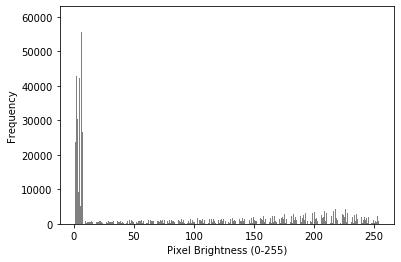

In [16]:
plt.hist(train_x, color=['gray']*train_x.shape[1], bins = 30)
plt.xlabel("Pixel Brightness (0-255)")
plt.ylabel("Frequency")
#plt.savefig('grey_freq.png')

One consideration is that currently the RGB value ranges from 0-255, however this can be scaled to be a value between 0-1 by dividing by 255. This should not affect the classification results itself, but will allow us to train all subsequent models quicker than should the values range from 0-255.

In [17]:
train_x = train_x / 255
test_x = test_x / 255
data = data / 255

# Logistic Regression 

Having completed an exploratory analysis of the data we can now begin with the modelling. It is important to note that as we have shown above, the data of interest is not binary as is typically the case for logisitic regression. Thus, we are performing multinomial logistic regression, as the response variable in this case consists of multiple classes.

As we are proceeding with multinomial logistic regression, the first consideration is the main assumption for multinomial logistic regression, that is we check whether there is relatively low colinearity within the data. 

However, one main issue with attempting to determine whether there is relatively low colinearity within the data, is that due to the size of the dataset, determining the correlation matrix is extremely computationally expensive. Possible ways in which this can be done is to make use of parallel computing or stratified sampling.

We now initialze our logistic regression object.

In [33]:
lbfgs = linear_model.LogisticRegression(max_iter = 100, solver = 'lbfgs', multi_class = 'multinomial', n_jobs = 12)

In [34]:
start = datetime.now()
lbfgs.fit(train_x, train_labels)
end = datetime.now()
time_taken = end - start

Having now fitted the model, we can evaluate the fit of the model.

In [35]:
label_pred = lbfgs.predict(test_x)

The confusion matrix and results are thus as follows:

In [36]:
print(metrics.classification_report(test_labels, label_pred))
confusion_matrix = metrics.confusion_matrix(test_labels, label_pred)
print(confusion_matrix)

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1000
           1       0.97      0.96      0.97      1000
           2       0.73      0.73      0.73      1000
           3       0.83      0.87      0.85      1000
           4       0.73      0.76      0.74      1000
           5       0.94      0.93      0.93      1000
           6       0.62      0.57      0.59      1000
           7       0.90      0.94      0.92      1000
           8       0.94      0.94      0.94      1000
           9       0.95      0.94      0.94      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

[[807   4  17  48   5   2 108   0   9   0]
 [  2 961   1  25   5   0   4   0   2   0]
 [ 19   6 735  12 131   1  86   0  10   0]
 [ 30  12  12 869  29   0  44   0   4   0]
 [  0   2 108  38 756   1  87   0   8   0]
 [  0   0   0   1   0 925 

In [37]:
print('Time: ',time_taken) 

Time:  0:00:58.518230


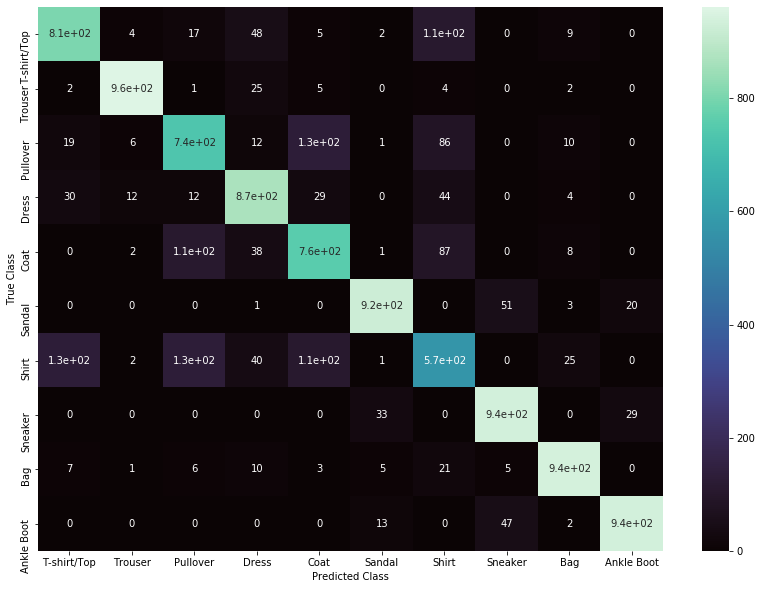

In [38]:
plt.figure(figsize= (14,10))
ax=sn.heatmap(confusion_matrix, annot=True,xticklabels = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'],
           yticklabels=['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'],cmap = 'mako')
ax.set(xlabel='Predicted Class', ylabel='True Class')
plt.show()

In order to ensure the results obtained above are indeed correct, cross validation of the results is performed.

However, in order to be able to make use of cross validation, we need to consider the entire dataset, and not only the current split of the data. Thus, we make use of the combined the training and test set from the original dataset and proceed from there. 

In [23]:
cv_results = cross_validate(lbfgs, data, target, cv=3)
print(f"Validation accuracy for each fold: {cv_results['test_score']}")
print(f"Average Accuracy:  {np.mean(cv_results['test_score'])}")

Validation accuracy for each fold: [0.85458987 0.8613123  0.84991214]
Average Accuracy:  0.8552714383081349


The final thing we do is to save the model itself so this can be used later.

In [25]:
filename = 'Final_LR.sav'
joblib.dump(lbfgs, filename)

['Final_LR.sav']

## K - Nearest Neighbours

The objective is now to be able to fit a K-nearest neighbours model to the data, the approach follows very closely to that which we did above.

Thus, we first create the k-NN object.

In [39]:
knn = KNeighborsClassifier(n_neighbors=6)

The model is now fitted:

In [40]:
start = datetime.now()
knn = knn.fit(train_x, train_labels)
end = datetime.now()
time_taken = end - start

Having fitted the model, the model is now evaluated.

In [29]:
label_pred = knn.predict(test_x)

In [30]:
print(metrics.classification_report(test_labels, label_pred))
confusion_matrix = metrics.confusion_matrix(test_labels, label_pred)
print(confusion_matrix)

              precision    recall  f1-score   support

           0       0.76      0.87      0.81      1000
           1       0.99      0.97      0.98      1000
           2       0.71      0.83      0.77      1000
           3       0.90      0.86      0.88      1000
           4       0.80      0.75      0.77      1000
           5       0.99      0.83      0.91      1000
           6       0.67      0.56      0.61      1000
           7       0.88      0.97      0.92      1000
           8       0.97      0.95      0.96      1000
           9       0.91      0.96      0.93      1000

    accuracy                           0.85     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000

[[874   0  18  16   5   1  78   1   7   0]
 [  9 966   5  12   4   0   3   0   1   0]
 [ 24   2 830  11  68   0  65   0   0   0]
 [ 51   7  19 857  30   0  34   0   2   0]
 [  3   0 137  29 749   0  80   0   2   0]
 [  1   0   0   0   0 832 

In [31]:
print('Time: ',time_taken) 

Time:  0:00:22.416181


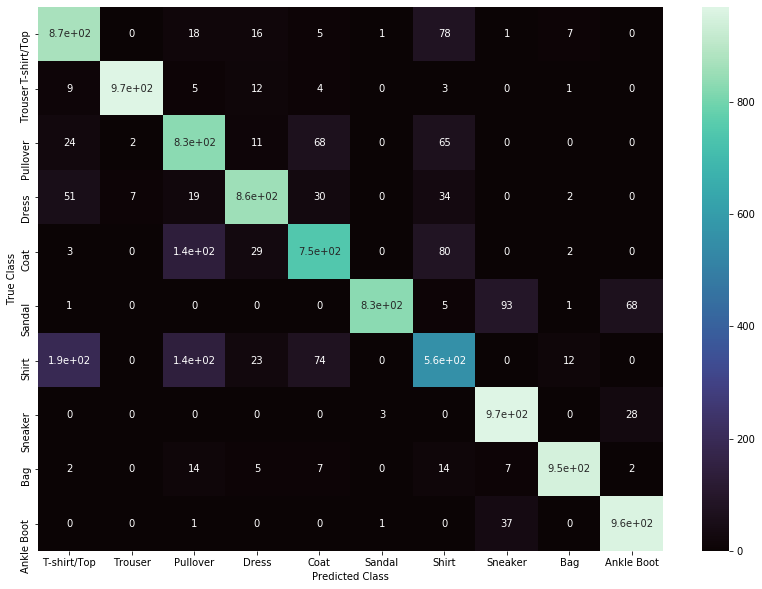

In [32]:
plt.figure(figsize= (14,10))
ax=sn.heatmap(confusion_matrix, annot=True,xticklabels = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'],
           yticklabels=['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'],cmap = 'mako')
ax.set(xlabel='Predicted Class', ylabel='True Class')
plt.show()

Unfortuantely due to the large number of dimensions within the dataset, there is no reasonable way to represent the classification results. But just as before, we will make use of cross validation to confirm the results which we have obtained above are indeed correct.

In [ ]:
cv_results = cross_validate(knn, data, target, cv=3)
print(f"Validation accuracy for each fold: {cv_results['test_score']}")
print(f"Average Accuracy:  {np.mean(cv_results['test_score'])}")

We now also want to be able to save the model, as before.

In [41]:
filename = 'Final_KNN.sav'
joblib.dump(knn, filename)

['Final_KNN.sav']

# Decision Tree

The objective is now to be able to fit a decision tree to the data, the approach follows very closely to that which we did above.

Thus, we first create the decision tree classifier.

In [46]:
clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = 15, max_features = 200)
#clf = DecisionTreeClassifier(criterion = 'entropy', splitter = 'random', max_depth = 15, max_features = 200)

The model is now fitted:

In [47]:
start = datetime.now()
clf = clf.fit(train_x, train_labels)
end = datetime.now()
time_taken = end - start

Having fitted the model, the model is now evaluated.

In [39]:
label_pred = clf.predict(test_x)

In [40]:
print(metrics.classification_report(test_labels, label_pred))
confusion_matrix = metrics.confusion_matrix(test_labels, label_pred)
print(confusion_matrix)

              precision    recall  f1-score   support

           0       0.79      0.76      0.77      1000
           1       0.96      0.94      0.95      1000
           2       0.67      0.70      0.69      1000
           3       0.83      0.82      0.83      1000
           4       0.69      0.69      0.69      1000
           5       0.92      0.90      0.91      1000
           6       0.55      0.56      0.55      1000
           7       0.88      0.91      0.89      1000
           8       0.92      0.92      0.92      1000
           9       0.92      0.91      0.91      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000

[[759   4  22  38   6   1 156   0  14   0]
 [ 10 943   5  26   4   0   8   0   4   0]
 [ 12   4 704  11 139   0 121   0   8   1]
 [ 32  21  24 821  46   2  46   0   7   1]
 [  7   1 151  36 694   1 101   0   9   0]
 [  1   1   1   0   0 895 

In [42]:
print('Time: ',time_taken) 

Time:  0:00:10.451721


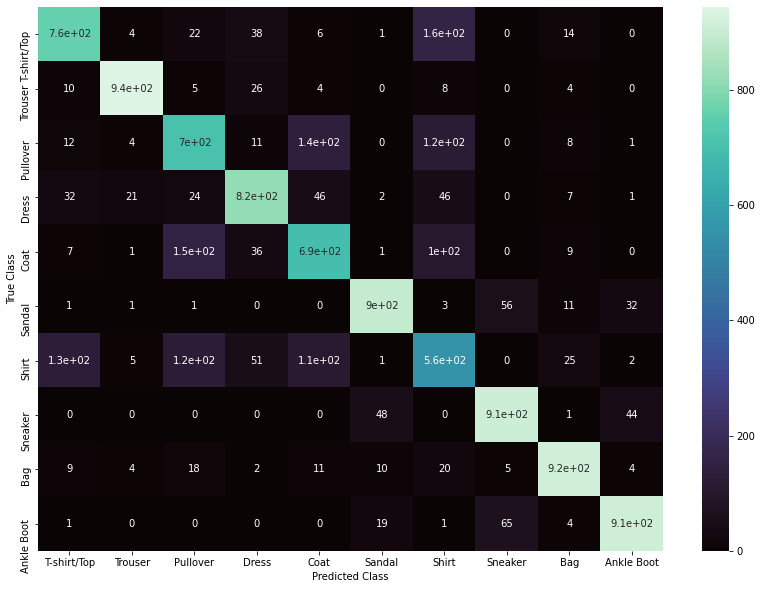

In [41]:
plt.figure(figsize= (14,10))
ax=sn.heatmap(confusion_matrix, annot=True,xticklabels = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'],
           yticklabels=['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'],cmap = 'mako')
ax.set(xlabel='Predicted Class', ylabel='True Class')
plt.show()

Unfortuantely due to the large size of the dataset, there is no reasonable way to visualize the decision tree. But just as before, we will make use of cross validation to confirm the results which we have obtained above are indeed correct.

In [43]:
cv_results = cross_validate(clf, data, target, cv=5)
print(f"Validation accuracy for each fold: {cv_results['test_score']}")
print(f"Average Accuracy:  {np.mean(cv_results['test_score'])}")

Validation accuracy for each fold: [0.81335714 0.808      0.81378571 0.81585714 0.80814286]
Average Accuracy:  0.8118285714285713


The model is now saved.

In [48]:
filename = 'Final_DT.sav'
joblib.dump(clf, filename)

['Final_DT.sav']

# Random Forest

The objective is now to be able to fit a random forest to the data, the approach follows very closely to that which we did above.

Thus, we first create the random forest classifier.

In [49]:
random_fs = RandomForestClassifier(criterion='entropy', max_depth=70, n_estimators=100)

The model is now fitted:

In [50]:
start = datetime.now()
clf = random_fs.fit(train_x, train_labels)
end = datetime.now()
time_taken = end - start

Having fitted the model, the model is now evaluated.

In [46]:
label_pred = random_fs.predict(test_x)

In [47]:
print(metrics.classification_report(test_labels, label_pred))
confusion_matrix = metrics.confusion_matrix(test_labels, label_pred)
print(confusion_matrix)

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1000
           1       0.99      0.96      0.98      1000
           2       0.76      0.79      0.78      1000
           3       0.88      0.90      0.89      1000
           4       0.76      0.82      0.79      1000
           5       0.98      0.96      0.97      1000
           6       0.73      0.59      0.65      1000
           7       0.93      0.95      0.94      1000
           8       0.95      0.97      0.96      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.87     10000
weighted avg       0.88      0.88      0.87     10000

[[859   0  11  32   4   1  81   0  12   0]
 [  2 963   3  23   3   0   4   0   2   0]
 [ 15   0 790  10 128   0  51   0   6   0]
 [ 23   3   9 902  33   0  28   0   2   0]
 [  0   1  97  32 820   0  47   0   3   0]
 [  0   0   0   1   0 962 

In [48]:
print('Time: ',time_taken) 

Time:  0:01:58.648314


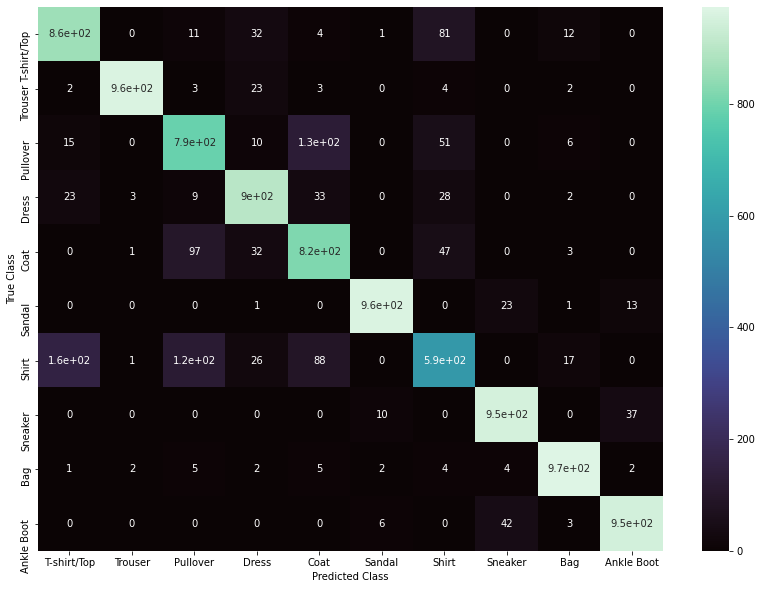

In [49]:
plt.figure(figsize= (14,10))
ax=sn.heatmap(confusion_matrix, annot=True,xticklabels = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'],
           yticklabels=['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'],cmap = 'mako')
ax.set(xlabel='Predicted Class', ylabel='True Class')
plt.show()

Unfortuantely due to the large size of the dataset, there is no reasonable way to visualize the random forest. But just as before, we will make use of cross validation to confirm the results which we have obtained above are indeed correct.

In [50]:
cv_results = cross_validate(random_fs, data, target, cv=3)
print(f"Validation accuracy for each fold: {cv_results['test_score']}")
print(f"Average Accuracy:  {np.mean(cv_results['test_score'])}")

Validation accuracy for each fold: [0.88017485 0.88599837 0.8786697 ]
Average Accuracy:  0.8816143062779161


In [51]:
filename = 'Final_RF.sav'
joblib.dump(random_fs, filename)

['Final_RF.sav']

# Support Vector Machine

The idea here is now to fit a support vector machine to the data.

In [52]:
svc = SVC(gamma='scale', kernel='rbf', C=8)

In [53]:
start = datetime.now()
svm = svc.fit(train_x, train_labels)
end = datetime.now()
time_taken = end - start

Having fitted the model, the model is now evaluated.

In [21]:
label_pred = svc.predict(test_x)

In [22]:
print(metrics.classification_report(test_labels, label_pred))
confusion_matrix = metrics.confusion_matrix(test_labels, label_pred)
print(confusion_matrix)

              precision    recall  f1-score   support

           0       0.83      0.86      0.85      1000
           1       0.99      0.97      0.98      1000
           2       0.81      0.84      0.82      1000
           3       0.90      0.91      0.90      1000
           4       0.84      0.83      0.84      1000
           5       0.97      0.97      0.97      1000
           6       0.75      0.71      0.73      1000
           7       0.95      0.96      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

[[859   0  12  22   5   1  95   0   6   0]
 [  2 973   1  18   2   0   4   0   0   0]
 [ 20   2 836  11  74   0  56   0   1   0]
 [ 27   3  14 908  25   0  18   0   5   0]
 [  0   1  86  21 834   0  57   0   1   0]
 [  0   0   0   1   0 974 

In [23]:
print('Time: ',time_taken) 

Time:  0:06:45.642614


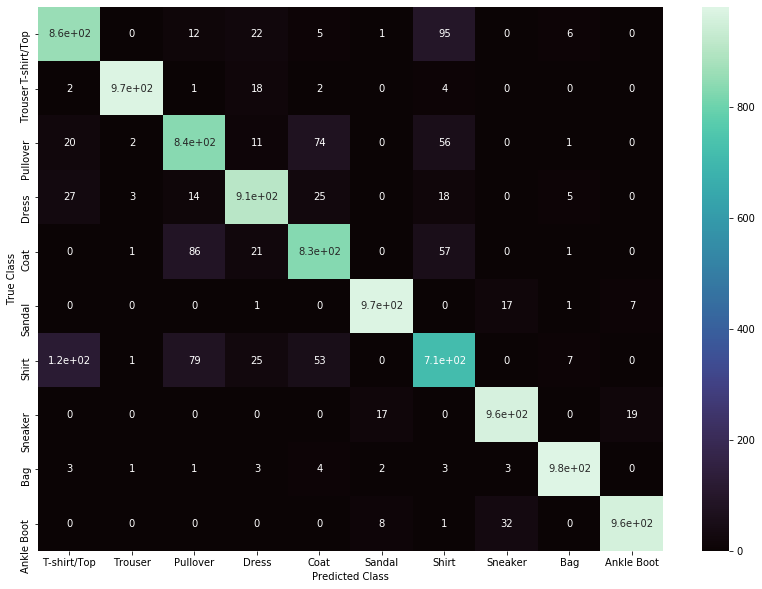

In [24]:
plt.figure(figsize= (14,10))
ax=sn.heatmap(confusion_matrix, annot=True,xticklabels = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'],
           yticklabels=['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'],cmap = 'mako')
ax.set(xlabel='Predicted Class', ylabel='True Class')
plt.show()

Once again we perform K-fold cross validation to ensure that the results obtained can be trusted.

In [25]:
cv_results = cross_validate(svc, data, target, cv=3  )
print(f"Validation accuracy for each fold: {cv_results['test_score']}")
print(f"Mean accuracy:  {np.mean(cv_results['test_score'])}")

Validation accuracy for each fold: [0.90233136 0.90558437 0.89799854]
Mean accuracy:  0.9019714234294497


In [55]:
filename = 'Final_SVM.sav'
joblib.dump(svc, filename)

['Final_SVM.h5']

# Convolutional Neural Network

The approach here is slightly more involved, and requires the definition of our own CNN model.

In [4]:
import collections
from sklearn import preprocessing
from sklearn.decomposition import PCA
from IPython.display import Markdown, display
import random
 
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from keras.layers.normalization import BatchNormalization
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input, UpSampling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, regularizers
from sklearn import metrics
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Model, load_model 

In [5]:
# Importing the train and test datasets
data_train = pd.read_csv(r"fashion-mnist_train.csv")
data_test = pd.read_csv(r"fashion-mnist_test.csv")

# Defining image dimensions
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

# Selecting the applicable values from the train dataset
X = np.array(data_train.iloc[:, 1:]) # All rows, columns starting from 1 till the end
y = to_categorical(np.array(data_train.iloc[:, 0])) # All rows, selecting column 0 and ensuring that it is categorical data

# Here we split data to train using 80% for training and 20% for testing
# Random state just ensure that the randomization is consistent with each run
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)

# Test data
X_test = np.array(data_test.iloc[:, 1:])
y_test = to_categorical(np.array(data_test.iloc[:, 0]))

# Reshaping the input to 4D for the CNN model
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

# Normalizing the data
# Converting the pixel values to the range [0,1]
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')
X_train /= 255 # Dividing by 255 since each of the pixel values lie between [0,255]
X_test /= 255
X_val /= 255

In [6]:
#checkpointer = ModelCheckpoint(filepath="save/cnn_mnist.hdf5", verbose=0, save_best_only=True) # Save best model

batch_size = 128 # This will imply that 48000 / 128 = 375 batch sample during testing
num_classes = 10 # Since the labels are from 0 - 9
epochs = 50 # this is the number of times the model goes through the training set. The model is updated after each batch size is processed.

model = Sequential() # Sequential allows us to create model layers to fit

# Block 1 of model
# Initial weights of the filter matrix is assigned according to the normal distribution
model.add(Conv2D(32, kernel_size=(3, 3),
                 kernel_initializer='he_normal',
                 input_shape=input_shape))
model.add(LeakyReLU())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.35))

# Block 2 of model
model.add(Conv2D(64, (3, 3)))
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

# Flatting of the model
# Basically reshapes the tensor to have the shape that is equal to the number of elements contained in tensor non including the batch dimension
model.add(Conv2D(128, (3, 3)))
model.add(LeakyReLU())
model.add(Dropout(0.45))
model.add(Flatten())

# The Dense layers and the output layers of the model
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.45))

# Notice that the output layer has 10 neurons
# Softmax ensures that the sum of outputs is 1 i.e., they are probabilities. 
# Similar to sigmoid however we have more than 2 classes, therefore softmax is better.
model.add(Dense(num_classes, activation='softmax'))

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

learning_rate = 0.001

# loss = categorical_crossentropy, since it is used for Multi-class classification
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=learning_rate), metrics=['accuracy'])


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 11, 11, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0

In [8]:
start = datetime.now()

history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(X_val, y_val))

end = datetime.now()
time_taken = end - start

Epoch 1/50
375/375 - 19s - loss: 0.7811 - accuracy: 0.7113 - val_loss: 0.4953 - val_accuracy: 0.8127
Epoch 2/50
375/375 - 19s - loss: 0.5000 - accuracy: 0.8196 - val_loss: 0.3697 - val_accuracy: 0.8657
Epoch 3/50
375/375 - 19s - loss: 0.4330 - accuracy: 0.8429 - val_loss: 0.3612 - val_accuracy: 0.8669
Epoch 4/50
375/375 - 19s - loss: 0.4011 - accuracy: 0.8543 - val_loss: 0.3355 - val_accuracy: 0.8745
Epoch 5/50
375/375 - 19s - loss: 0.3885 - accuracy: 0.8591 - val_loss: 0.3177 - val_accuracy: 0.8816
Epoch 6/50
375/375 - 19s - loss: 0.3734 - accuracy: 0.8640 - val_loss: 0.3060 - val_accuracy: 0.8859
Epoch 7/50
375/375 - 19s - loss: 0.3665 - accuracy: 0.8669 - val_loss: 0.3067 - val_accuracy: 0.8842
Epoch 8/50
375/375 - 19s - loss: 0.3544 - accuracy: 0.8718 - val_loss: 0.3011 - val_accuracy: 0.8852
Epoch 9/50
375/375 - 19s - loss: 0.3503 - accuracy: 0.8729 - val_loss: 0.2925 - val_accuracy: 0.8921
Epoch 10/50
375/375 - 19s - loss: 0.3446 - accuracy: 0.8749 - val_loss: 0.2882 - val_accura

In [9]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.9072999954223633


In [27]:
label_pred = model.predict(X_test)
label_pred = np.argmax(label_pred,axis=1)
y_true = np.argmax(y_test,axis=1)

In [28]:
print(metrics.classification_report(y_true, label_pred))
confusion_matrix = metrics.confusion_matrix(y_true, label_pred)
print(confusion_matrix)

              precision    recall  f1-score   support

           0       0.87      0.84      0.86      1000
           1       0.99      0.99      0.99      1000
           2       0.90      0.83      0.86      1000
           3       0.90      0.94      0.92      1000
           4       0.83      0.91      0.86      1000
           5       0.99      0.96      0.98      1000
           6       0.77      0.76      0.76      1000
           7       0.95      0.96      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.96      0.97      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

[[845   0  19  22   2   0 103   1   8   0]
 [  0 987   1  10   0   0   2   0   0   0]
 [ 17   0 830  13 103   0  36   0   1   0]
 [  9   2   7 939  25   0  18   0   0   0]
 [  0   0  15  24 906   0  55   0   0   0]
 [  0   1   0   0   0 962 

In [15]:
print('Time: ',time_taken) 

Time:  0:16:08.455133


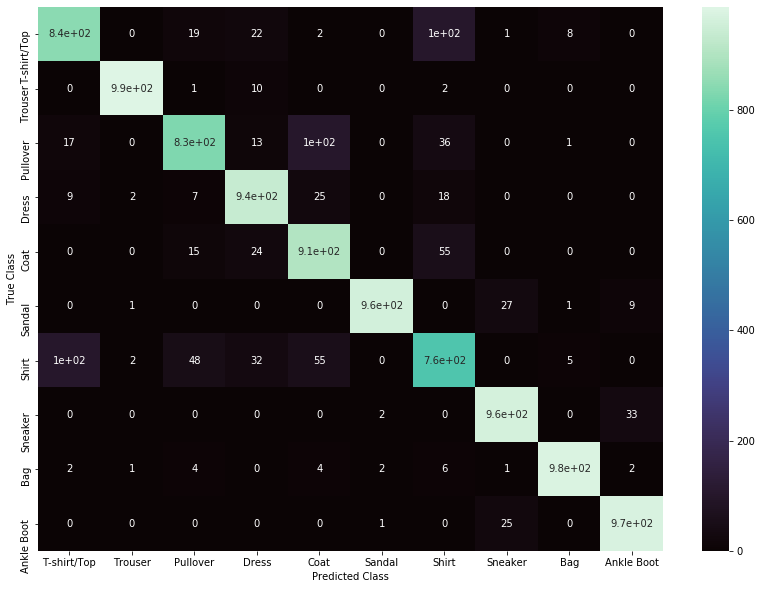

In [29]:
plt.figure(figsize= (14,10))
ax=sn.heatmap(confusion_matrix, annot=True,xticklabels = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'],
           yticklabels=['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'],cmap = 'mako')
ax.set(xlabel='Predicted Class', ylabel='True Class')
plt.show()

In [13]:
model.save("Final_CNN")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Final_CNN\assets


In [14]:
X_test

array([[[[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.01568628],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.00392157],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        ...,

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]]],


       [[[0.        ],
         [0.        ],
         [0.  

In [15]:
X_test.shape

(10000, 28, 28, 1)